## Main Project - Creating an index of labor demand

In this notebook, we use Json-files containing job ads between 2006 - 2019 downloaded through the initiative [Jobtech](https://jobtechdev.se/). After some cleaning, this data is then queried through an SQlite repository. Finally, an index of labor demand is created and used for further analysis.

The analysis can be split into three parts:
 - Checking trend and seasonal components using LOESS
 - Checking Cointegration level using Engle-Granger test
 - Examining relation with Statistics Sweden's quarterly survey of Labor Demand using OLS
 
Finally, the index will be broken down by demand per city and analyzed further.

In [85]:
#Importing relevant packages
import json
import csv
import pandas as pd
from pandas import DataFrame
import sqlite3
import numpy as np
import calendar
from calendar import monthrange
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from arch.unitroot import engle_granger
from arch.unitroot import ADF

### Converting and cleaning Json-files

The files downloaded through Jobtech are in Json-format. The first step is therefore to transform these into CSV-files more suitable for SQlite. In this process they are also cleaned from aberrations.

In [57]:
%%time
#Extracting variables of interest and saving as CSV
total_valid = 0; total_errors = 0
for i in range(2013,2014):
    filename = "/Users/wilhelmakesson/Desktop/Master Thesis/Data/{}.json".format(i) 
    with open(filename) as f:
        ads = json.load(f)
        new_list = []
        error_rows = 0
    
    for ad in ads:
        if i != 2017:
            try: 
                x = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['application_deadline'][:10], ad['workplace_address']['municipality_code']]
                new_list.append(x)
            except:
                error_rows += 1
                continue
        else:
            try:
                x = [head_line, int(ad['number_of_vacancies']), ad['publication_date'][:10], ad['last_publication_date'][:10], ad['workplace_address']['municipality_code']]
                new_list.append(x)
            except:
                error_rows += 1
                continue
    
    with open("/Users/wilhelmakesson/Desktop/Master Thesis/Data/{}.csv".format(i) , mode='w', newline="") as file_writer:
            write = csv.writer(file_writer)
            for row in new_list:
                write.writerow(row)
    print(f'valid ads for {i}: ' + str(len(new_list)), ' | ', f'erroneous ads for {i}: ' + str(error_rows))
    total_valid += len(new_list); total_errors += error_rows
print('\n')
print('total valid ads: ' + str(total_valid), '  |  ', 'total erroneous ads: '+ str(total_errors))

valid ads for 2013: 0  |  erroneous ads for 2013: 390053


total valid ads: 0   |   total erroneous ads: 390053
CPU times: user 45.8 s, sys: 2min 7s, total: 2min 53s
Wall time: 11min 14s


### Query SQlite
The files have been channeled through an SQlite database (see file SQLite3_db in repository). This enables us to efficiently query the amount of active job ads, meaning ads that have passed publication date but not applicaiton deadline a certain date. From these active job ads, we can extract the number of available jobs for each ad, as well as in which city the person is expected to work.  

In [ ]:
conn = sqlite3.connect("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/muni.db")
cursor = conn.cursor()
columns = []
columns.append(["Date", "Rural Municipality", "Rural municipality with hospitality industry", "Low commuting municipality near major city"
, "Small town/urban area", "Commuting municipality near smaller urban area", "Commuting municipality near big city", "Commuting municipality near major city"
,"Metropolitan areas", "Big cities"])

#Finding the number of active ads per given time period
for year in range(2006,2021):
    for month in range(1,13):
# We have to skip first month since some groups have values of zero #
        if year == 2006 and month == 1:
            continue
        for day in range(1, calendar.monthrange(year, month)[1]+1):
            if day < 10 and month < 10:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-0{month}-0{day}' >= publication_date AND '{year}-0{month}-0{day}' <= application_deadline GROUP BY municipality_group;"
            elif month < 10 and day >9:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-0{month}-{day}' >= publication_date AND '{year}-0{month}-{day}' <= application_deadline GROUP BY municipality_group;"
            elif day < 10 and month >9:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-{month}-0{day}' >= publication_date AND '{year}-{month}-0{day}' <= application_deadline GROUP BY municipality_group;"
            else:
                query = f"SELECT SUM(number_of_vacancies) vacancies, municipality_group_name municipality_group FROM joined_table WHERE '{year}-{month}-{day}' >= publication_date AND '{year}-{month}-{day}' <= application_deadline GROUP BY municipality_group;"

            data = cursor.execute(query).fetchall()
            ads_per_day = [f'{year}-{month}-{day}', data[0][0], data[1][0], data[2][0], data[3][0], data[4][0], data[5][0], data[6][0], data[7][0], data[8][0]]
            columns.append(ads_per_day)

conn.close()
job_df = pd.DataFrame(columns[1:], columns=columns[0])
df.head()

### Combining with Statistics Sweden's Quarterly Vacancy Survey

To confirm that our digital job index can be used as a measure of labor demand it will be compared to a more established measure of labor demand by Statistics Sweden. Their [quarterly vacancy survey](https://www.statistikdatabasen.scb.se/pxweb/en/ssd/START__AM__AM0701__AM0701A/KV15LedigajobbVak07/) will be compared both graphically and through OLS estimation with the daily digital job index.

In [112]:
job_df = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/results.csv", names=["Date", "Vacancies"])
job_df = job_df.set_index(pd.to_datetime(job_df['Date'])).drop('Date', axis=1)
labor_survey = pd.read_csv("/Users/wilhelmakesson/Desktop/Master Thesis/Data/muni_int/lediga_jobb.csv").drop('quarter', axis=1)
labor_survey = labor_survey.set_index(pd.date_range('2006-01-01','2020-12-01', freq='Q'))

In [87]:
# Creating range and labels for plot x-axis #
date_index = pd.date_range('2006','2022', freq='Y')
date_index = date_index.values.astype('datetime64[Y]')
date_range = np.arange(2006, 2022)

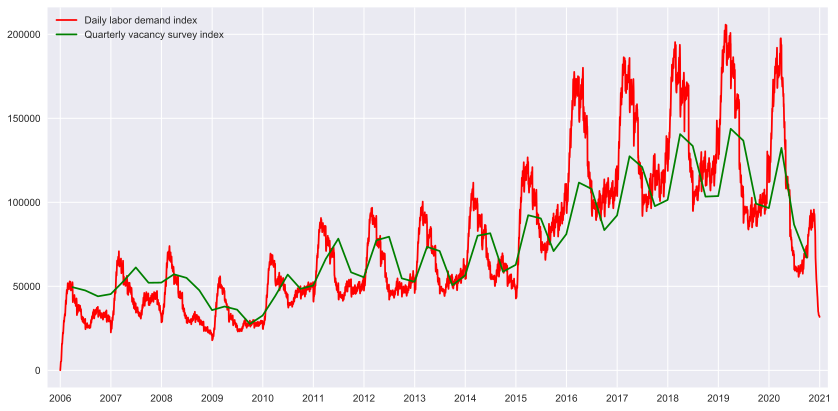

In [88]:
#Plotting quarterly survey against daily digital job index
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(14,7))

plt.plot(job_df.index, job_df, label='Daily labor demand index', color='red')
plt.plot(labor_survey.index, labor_survey, label='Quarterly vacancy survey index', color='green')

plt.xticks(ticks=date_index, labels=date_range)
plt.xlim(datetime(2005,10,1), datetime(2021,3,1))
plt.legend()

plt.show()

### Preliminary results

The two indices show a striking similarity, but with the digital job ads index having significantly higher spikes beginning in 2016. One hypothesis behind this is that professional recruiters started creating automatized systems for posting ads online around this time. 

We will now move on to analyze the trend, season and residual variance separately using LOESS:

In [96]:
#Decomposition of digital job ads index
stl_d = STL(job_df, period=365)
daily_result = stl_d.fit()

#Decomposition of quarterly survey index
stl_q = STL(labor_survey, period=4)
quarterly_result = stl_q.fit()

seasonal_d, trend_d, resid_d = daily_result.seasonal, daily_result.trend, daily_result.resid
seasonal_q, trend_q, resid_q = quarterly_result.seasonal, quarterly_result.trend, quarterly_result.resid

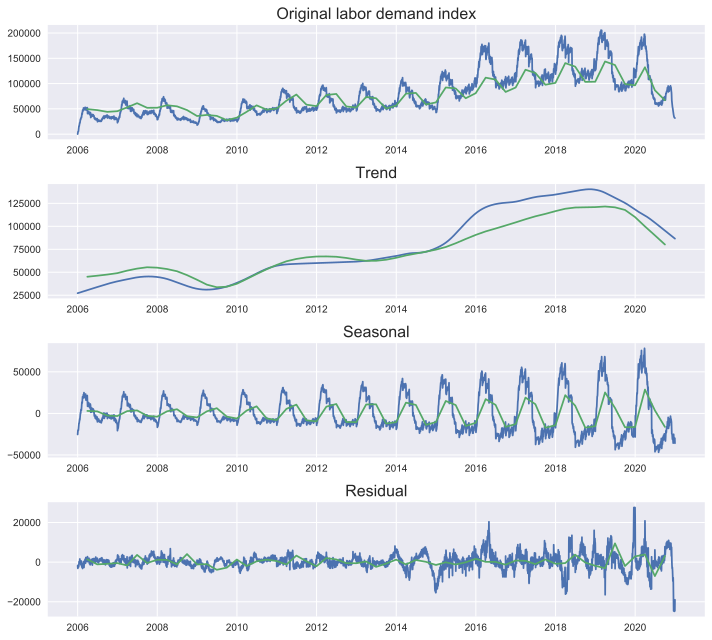

In [124]:
#Plotting seasonal, trend and residual variance for both indices
plt.figure(figsize=(10,9))

plt.subplot(4,1,1)
plt.plot(job_df)
plt.plot(labor_survey)
plt.title('Original labor demand index', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_d)
plt.plot(trend_q)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_d)
plt.plot(seasonal_q)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_d)
plt.plot(resid_q)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Text(0.5, 1.0, 'predicted vs real job ads index')

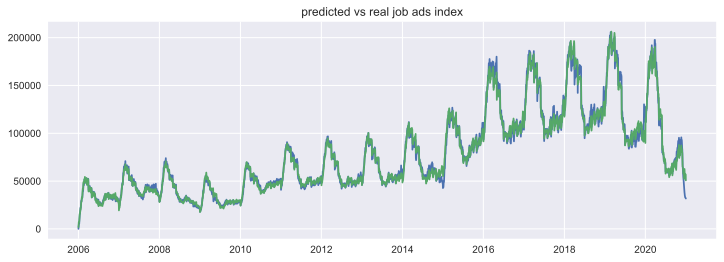

In [131]:
#Comparing predicted values based on trend and seasonal variation with original values
estimated = trend_d + seasonal_d
plt.figure(figsize=(12,4))
plt.plot(job_df)
plt.plot(estimated)
plt.title("predicted vs real job ads index")

In [101]:
resid_mu = resid_d.mean()
resid_dev = resid_d.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(732312.0, 737791.0)

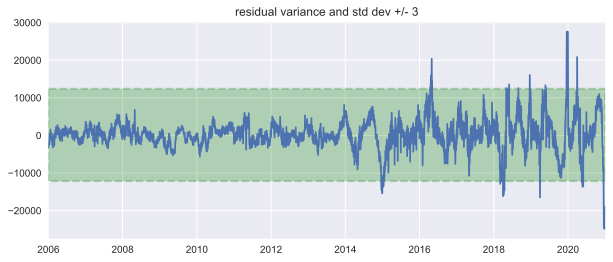

In [130]:
#Checking abberations from season and trend pattern over time
plt.figure(figsize=(10,4))
plt.plot(resid_d)
plt.title("residual variance and std dev +/- 3")

plt.fill_between([datetime(2006,1,1), datetime(2021,1,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2006,1,1), datetime(2021,1,1))

### LOESS Results

The charts above visualize how the digital job ads index shares both trend and seasonal pattern with the quarterly vacancy survey. However, it also shows how both seasonal and trend patterns are somewhat more off after 2015. This is even more visible in the Residual-chart. Their could be many explanations behind this, and these will be explored in the final analysis. 

Below, we will make a more formal comparison between the two indices using OLS estimation to show how well they explain each other, and an Engle-Granger test for possible co-integration.

In [135]:
#First, the daily index need to be resampled to quarterly frequency for the regressions to work
results_resampled = job_df.resample('Q').mean().iloc[:-1,:]
job_df_q = results_resampled.join(labor_survey).rename(columns={'Total':'survey_vacancies'})
job_df_q.head()

,Vacancies,survey_vacancies
Date,,
2006-03-31,36269.888889,49486
2006-06-30,36032.846154,47554
2006-09-30,30377.695652,44060
2006-12-31,32200.891304,45379
2007-03-31,51418.855556,52874


In [134]:
#A variance-bias decomposition to see how much of the model's error is due to variance and what is due to bias
y = job_df_q.iloc[:,1].values
X = job_df_q.iloc[:,0].values
X = X.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

ols_lin = LinearRegression()

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        ols_lin, X_train, y_train, X_test, y_test, 
        loss='mse',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 30804316.778
Average bias: 28237624.766
Average variance: 2566692.012


In [132]:
#A preliminary train/test model of OLS seeing how well it predicts itself
y = job_df_q.iloc[:,1].values
X = job_df_q.iloc[:,0].values
X = X.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

LinReg = LinearRegression().fit(X_train, y_train)
y_prediction = LinReg.predict(X_test)
y_prediction

array([105100.9723315 , 119307.66587814,  43283.58587494, 124582.85996989,
        55714.43713466,  53885.287419  , 135192.89719126,  90483.98815865,
        50599.28643372,  54650.61591582,  59002.23198278,  55806.00739916,
        38108.12746317,  45888.08622851,  53448.47828149,  41884.23902598,
        94437.15407566,  58971.21396739])

In [119]:
ols = sm.OLS(job_df_q.iloc[:,1], job_df_q.iloc[:,0]).fit()
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:       survey_vacancies   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              2774.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.12e-50
Time:                        11:58:25   Log-Likelihood:                         -635.50
No. Observations:                  59   AIC:                                      1273.
Df Residuals:                      58   BIC:                                      1275.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### OLS results

Initial OLS estimation show how the digital job ads index explain almost 100% of the variation in the quarterly survey. This is a strong indication of that they seem to measure the same phenomena: labor demand. To make sure the result is not contaminated by the trend or a unit-root, the test will be verified by an Engle-Granger test below.

In [127]:
eg_test = engle_granger(job_df_q.iloc[:,1], job_df_q.iloc[:,0], trend="c")
eg_test

Test Statistic,-4.837
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),0.419
